In [203]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import zipfile, os

In [204]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


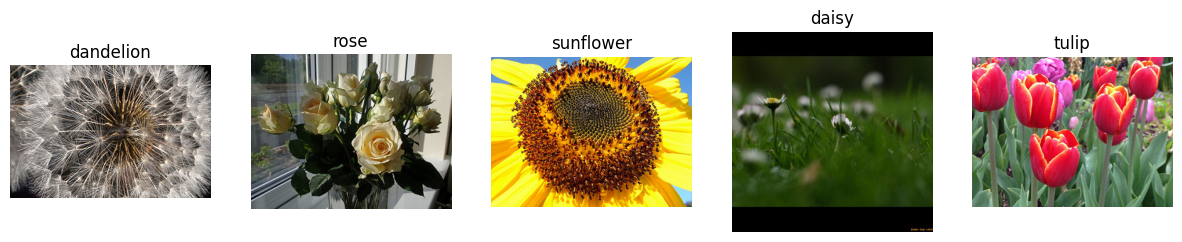

In [219]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/flowers.zip'
extract_path = '/content/flower_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


plt.figure(figsize=(15, 10))

# Loop through each class and display one image
for i, class_name in enumerate(class_names):
    # Get the path to the first image in the class directory
    image_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[26])

    # Read and display the image
    img = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()


In [ ]:
train_path = "/content/flower_dataset/flowers/train"
test_path = "/content/flower_dataset/flowers/test"

In [ ]:
#  ImageDataGenerator
train_val_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_image_generator = train_val_gen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)


val_image_generator = train_val_gen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = test_gen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.
Found 664 images belonging to 5 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes

model = Model(inputs=base_model.input, outputs=predictions)

/tmp/ipython-input-685431339.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


In [ ]:
#  Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [ ]:
history = model.fit(
    train_image_generator,
    validation_data=val_image_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 626ms/step - accuracy: 0.2691 - loss: 2.1581 - val_accuracy: 0.5310 - val_loss: 1.2152 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - accuracy: 0.4709 - loss: 1.3184 - val_accuracy: 0.6405 - val_loss: 0.9959 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - accuracy: 0.5819 - loss: 1.0565 - val_accuracy: 0.7263 - val_loss: 0.8227 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 464ms/step - accuracy: 0.6592 - loss: 0.9273 - val_accuracy: 0.7336 - val_loss: 0.7457 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step - accuracy: 0.6747 - loss: 0.8623 - val_accuracy: 0.7609 - val_loss: 0.7097 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.6821 - loss: 0.8387 - val_accuracy: 0.7774 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 462ms/step - acc

In [ ]:
import pandas as pd
df_metrics = pd.DataFrame(history.history)
df_metrics.to_csv("training_metrics.csv", index=False)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


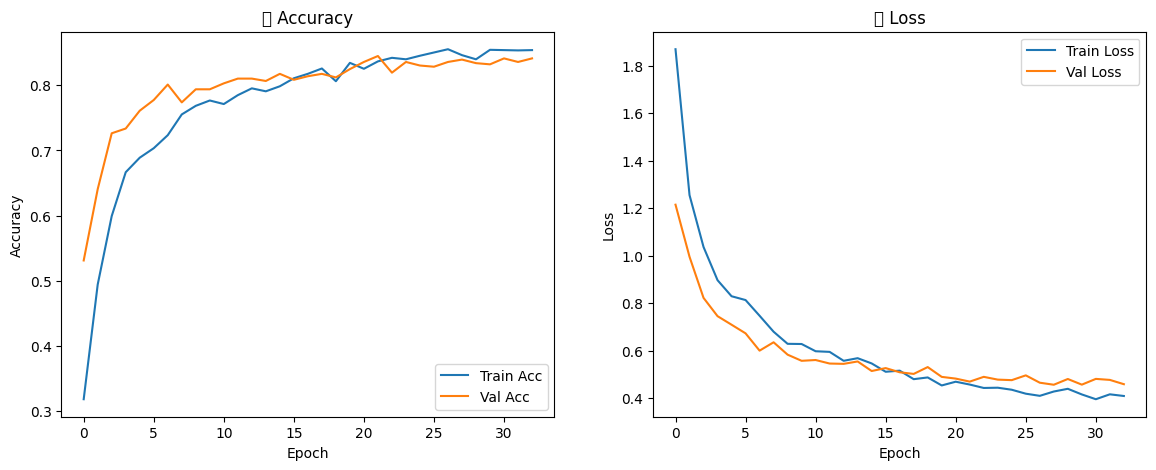

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('📈 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('📉 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# ทำนายผลบน test set
Y_pred = model.predict(test_image_generator)
y_pred = np.argmax(Y_pred, axis=1)

# ค่า target class จริง
y_true = test_image_generator.classes

# ชื่อคลาส
class_labels = list(test_image_generator.class_indices.keys())

# แสดง classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step
              precision    recall  f1-score   support

       daisy       0.84      0.84      0.84        95
   dandelion       0.90      0.62      0.73       143
        rose       0.75      0.92      0.83       107
   sunflower       0.84      0.93      0.88       153
       tulip       0.86      0.89      0.87       166

    accuracy                           0.84       664
   macro avg       0.84      0.84      0.83       664
weighted avg       0.84      0.84      0.83       664



Saving 00.jpg to 00.jpg


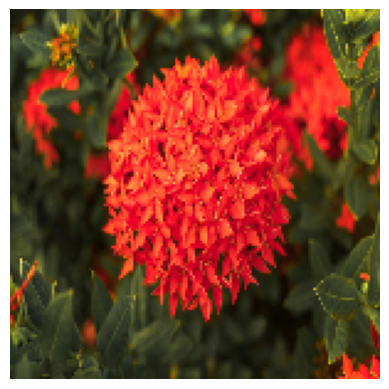

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Uploaded image: 00.jpg
Unknown flower type


In [227]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Rescale the image

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    max_prob = np.max(classes[0])
    predicted_class_index = np.argmax(classes[0])
    predicted_class_label = class_labels[predicted_class_index]

    print(f"Uploaded image: {fn}")
    if max_prob > 0.7: # You can adjust this threshold
        print(f"Predicted class: {predicted_class_label}")
        print(f"Confidence: {max_prob:.2f}")
    else:
        print("Unknown flower type")

Saving ฟกกก.jpg to ฟกกก.jpg


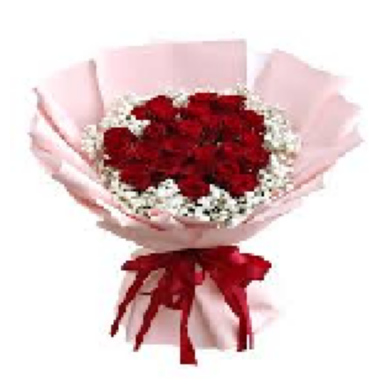

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Uploaded image: ฟกกก.jpg
Predicted class: rose
Confidence: 0.97


In [222]:

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Rescale the image

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    max_prob = np.max(classes[0])
    predicted_class_index = np.argmax(classes[0])
    predicted_class_label = class_labels[predicted_class_index]

    print(f"Uploaded image: {fn}")
    if max_prob > 0.7: # You can adjust this threshold
        print(f"Predicted class: {predicted_class_label}")
        print(f"Confidence: {max_prob:.2f}")
    else:
        print("Unknown flower type")

In [234]:
!cp "/content/drive/MyDrive/Colab Notebooks/flowers.ipynb" .
!cp "/content/drive/MyDrive/training_metrics.csv" .


cp: cannot stat '/content/drive/MyDrive/training_metrics.csv': No such file or directory
